In [77]:
from pulp import *
from itertools import product

import cv2
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt


%matplotlib inline

## OpenCV

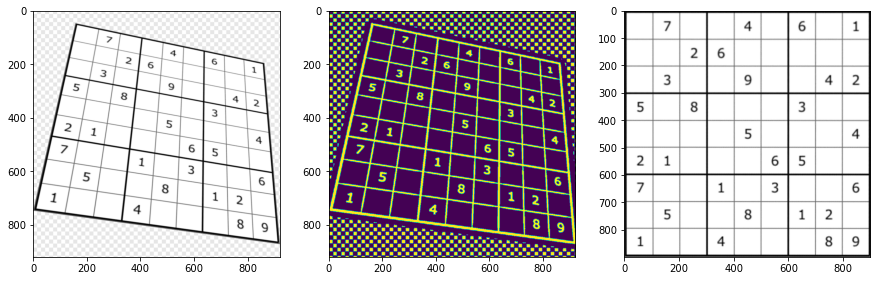

In [78]:
# Открываем изображение с судоку
img = cv2.imread('examples/7.png')

# Находим квадрат с судоку
blurry = cv2.GaussianBlur(img, (5, 5), 5)
gray = cv2.cvtColor(blurry, cv2.COLOR_BGR2GRAY)
thresh = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV,77,5)
grabs,_ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

grabs = sorted(grabs, key=cv2.contourArea, reverse=True)
location = None
for grab in grabs:
    approx = cv2.approxPolyDP(grab, 15, True)
    if len(approx) == 4:
        rect = np.zeros((4, 2), dtype = "float32")
        cutt = approx[:,0]
        s = cutt.sum(axis = 1)
        
        # Сортировка углов по часовой стрелке
        rect[0] = cutt[np.argmin(s)]
        rect[2] = cutt[np.argmax(s)]
        diff = np.diff(cutt, axis = 1)
        rect[1] = cutt[np.argmin(diff)]
        rect[3] = cutt[np.argmax(diff)]
        location = rect
        break

height = 900
width = 900
pts1 = np.float32([location[0], location[1], location[3], location[2]])
pts2 = np.float32([[0, 0], [width, 0], [0, height], [width, height]])

# Трансформируем перспективу
matrix = cv2.getPerspectiveTransform(pts1, pts2)
board = cv2.warpPerspective(img, matrix, (width, height))

fig, ax = plt.subplots(1,3, figsize=(15,15))
for i, j in zip(range(len(ax)), [img, thresh, board]):
    ax[i].imshow(j)

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
c:\Users\lol\anaconda3\lib\site-packages\torchvision\models\_utils.py:252: UserWarning: Accessing the model URLs via the internal dictionary of the module is deprecated since 0.13 and will be removed in 0.15. Please access them via the appropriate Weights Enum instead.
  warnings.warn(
c:\Users\lol\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
c:\Users\lol\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


,1,2,3,4,5,6,7,8,9
1,,7,,,4,,6,,1
2,,,2,6,,,,,
3,,3,,,9,,,4,2
4,5,,8,,,,3,,
5,,,,,5,,,,4
6,2,1,,,,6,5,,
7,7,,,1,,3,,,6
8,,5,,,8,,1,2,
9,,,,4,,,,8,9


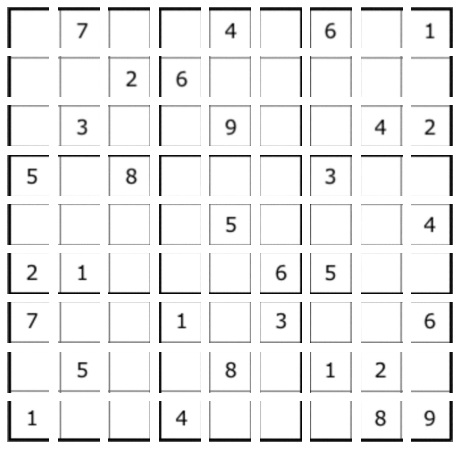

In [79]:
import easyocr
reader = easyocr.Reader(['en'])
df = pd.DataFrame(index=range(1, 10), columns=range(1, 10))

fig, ax = plt.subplots(9, 9, figsize=(8,8))
split = np.split(board, 9, axis=1)
plmat = []
for col,j  in enumerate(split):
    digs = np.split(j, 9)
    for row,d in enumerate(digs):
        # d = d[10:90, 10:90]       
        ax[row][col].imshow(d)
        ax[row][col].axis('off')

        text = reader.readtext(d, allowlist='0123456789', detail=False)

        if len(text) > 0:
            df.iloc[row, col] = text[0]
            plmat.append([text[0], str(row+1), str(col+1)])

df.fillna('', inplace=True)
df

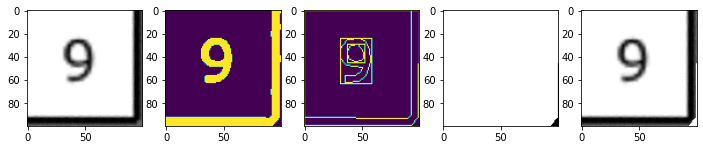

In [80]:
d = digs[8]

g = d.copy()
e = g.copy()

g = cv2.cvtColor(g, cv2.COLOR_BGR2GRAY)
g = cv2.GaussianBlur(g, (5,5), 5)
g = cv2.adaptiveThreshold(g, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 37, 5)
kernel = cv2.getStructuringElement(shape=cv2.MORPH_ELLIPSE, ksize=(1,3))
g = cv2.morphologyEx(g, cv2.MORPH_OPEN, kernel, iterations=2)

cnts, _ = cv2.findContours(g, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

contours_poly = [None for i in range(len(cnts))]
boundRect = [None for i in range(len(cnts))]

for i, c in enumerate(cnts):
    contours_poly[i] = cv2.approxPolyDP(c, 1, True)
    boundRect[i] = cv2.boundingRect(contours_poly[i])

drawing = np.zeros((g.shape[0], g.shape[1], 3), dtype=np.uint8)
    
    
for i in range(len(cnts)):
    color = 255
    cv2.drawContours(drawing, contours_poly, i, color, 1)
    cv2.rectangle(drawing, (int(boundRect[i][0]), int(boundRect[i][1])), (int(boundRect[i][0]+boundRect[i][2]), int(boundRect[i][1]+boundRect[i][3])), color, 1)

drawing = cv2.cvtColor(drawing, cv2.COLOR_BGR2GRAY)
fincnts, _ = cv2.findContours(drawing, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
fincnts = sorted(fincnts, key=cv2.contourArea, reverse=True)
finmask = np.zeros_like(e)

cv2.drawContours(finmask, fincnts[:1], -1, (255,255,255), -1)
rst = cv2.bitwise_and(e, finmask)
rst[finmask==0] = 255


ls = [d,g, drawing, finmask, rst]
fig, ax = plt.subplots(1,len(ls), figsize=(12,12))
for i, j in zip(range(len(ax)), ls):
    ax[i].imshow(j)

## Pulp

In [81]:
nums = [*map(str, [*range(1,10)])] # список чисел от 1 до 9 со строковым типом
rows = nums
cols = nums
vals = nums

choices = LpVariable.dicts("Choice", (vals, rows, cols), 0, 1, LpInteger)

In [82]:
prob = LpProblem("Судоку", LpMaximize)
prob += 0, "Целевая функция" # Задаётся нулём, так как нас интересует только подбор значения согласно ограничениям

In [83]:
for r, c in product(rows, cols):
    prob += lpSum([choices[v][r][c] for v in vals]) == 1, ""

for v, r in product(vals, rows):
    prob += lpSum([choices[v][r][c] for c in cols]) == 1, ""

for v, c in product(vals, cols):
    prob += lpSum([choices[v][r][c] for r in rows]) == 1, ""

In [84]:
grid = range(3)
subs = [[(rows[3*i+k],cols[3*j+l]) for k,l in product(grid, grid)] for i,j in product(grid, grid)]

for v,s in product(vals, subs):
    prob += lpSum([choices[v][r][c] for (r, c) in s]) == 1, ""

In [85]:
sudoku_map = plmat.copy()
for i in plmat:
    if i[0] == '':
        sudoku_map.remove(i)
        
for num in sudoku_map:
    prob += choices[num[0]][num[1]][num[2]] == 1, ""

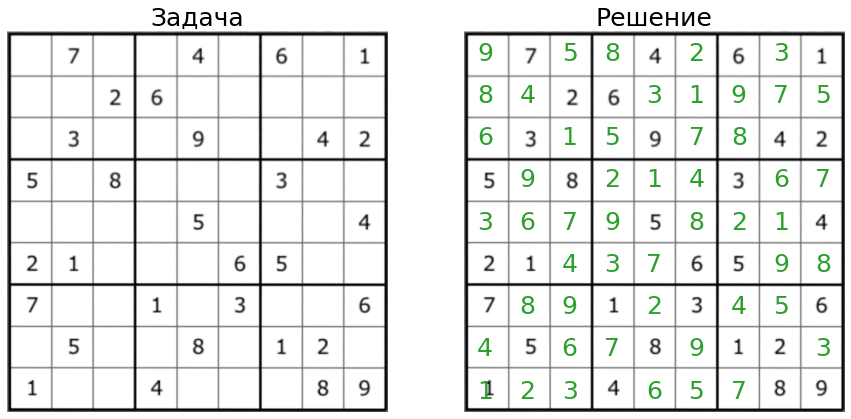

In [86]:
prob.solve()

fig, axes = plt.subplots(1,2, figsize=(15,15))
axes[0].imshow(board)
axes[0].set_title('Задача', fontsize=25)
axes[1].imshow(board)
axes[1].set_title('Решение', fontsize=25)
for a in axes:
    a.axis('off')

y = 50
for r in rows:
    x = 50
    for c,v in product(cols, vals):
        if choices[v][r][c].value() == 1:
            if [v,r,c] not in sudoku_map:
                axes[1].text(x,y,v, ha='center', va='center', fontsize=25, color='tab:green')
            x += 100
    y += 100
